Along **`Practical Statistics for Data Scientists`** book 

Chapter 3 : Statistical Experiments and Significance Testing

<a id=top></a>
[Go to bottom](#bottom)

In [23]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.utils import resample
from scipy.stats import stats

import os
import random

In [2]:
def populate_data(filename) :
    data_path = os.path.join(os.getcwd(), 'data') + '/' + filename
    df = pd.read_csv(data_path)
    print(df.info())
    print(df.head())
    return df

## Resampling
Boostrapping and Permutation test

- Bootstrapping : estimate the sampling distribution of a statistic or parameters by replicating samples with replacement n repeating times - not compensate for a small sample size nor create a new data but powerful tool for assessing the variability of a sample statistic 
- Permutation test : multiple samples are combined and the sampling may be done without replacement

In [3]:
loans_income = populate_data('loans_income.csv')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   x       50000 non-null  int64
dtypes: int64(1)
memory usage: 390.8 KB
None
        x
0   67000
1   52000
2  100000
3   78762
4   37041


### Bootstrapping

In [4]:
results = []
for nrepeats in range(1000) :
    boot_sample = resample(loans_income, replace=True)
    results.append(boot_sample.median())

In [5]:
results = pd.Series(results)
results.shape

(1000,)

In [6]:
print('Bootstrap statistics : ')
print(f'Original: {loans_income.iloc[:,0].median()}')
print(f'bias: {results.mean() - loans_income.iloc[:,0].median()}')
print(f'std err: {results.std()}')

Bootstrap statistics : 
Original: 62000.0
bias: -70.57200000000012
std err: 205.11418684636527


The original estimate of the median is \\$62000. The boostrap distribution incidates that the estimate has a bias of about -\\$64 and a standard error of \\$209.

### Permutation Test
Practice with **Web Stickiness** example 

_A company wants to test which of two web presentations creates a better sales. Due to high value of the server being sold, sales are infrequent and the sales cycle is long; so the company will go with the results with a proxy variable. A selected metric is average session time, comparing page A to page B. The result is a total of 36 sessions for the two different presentations : 21 for page A and 15 for page B._

In [7]:
sessions_pages = populate_data('web_page_data.csv')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36 entries, 0 to 35
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Page    36 non-null     object 
 1   Time    36 non-null     float64
dtypes: float64(1), object(1)
memory usage: 704.0+ bytes
None
     Page  Time
0  Page A  0.21
1  Page B  2.53
2  Page A  0.35
3  Page B  0.71
4  Page A  0.67


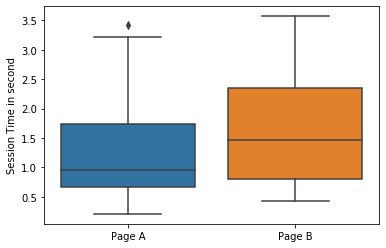

In [8]:
ax=sns.boxplot(data=sessions_pages, x='Page', y='Time')
ax.set_xlabel('')
ax.set_ylabel('Session Time in second')
plt.show()

In [9]:
mean_page_a = sessions_pages.query('Page=="Page A"').mean()
mean_page_b = sessions_pages.query('Page=="Page B"').mean()

In [10]:
obs_diff = (mean_page_b - mean_page_a)[0]
obs_diff

0.3566666666666669

The boxplot shows that page B held long sessions than page A. 0.35 more seconds on average.
So next is to confirm is the difference is statistically significant - by doing a permutation test.

how : combine all the session times together and then repeatedly shuffle. Divide them into a group of 21 (page A) and a group of 15 (page B).

In [11]:
def perm_test_two(x, nA, nB) :
    n = nA + nB
    idx_A = set(random.sample(range(n), nA))
    idx_B = set(range(n)) - idx_A
    return x.loc[idx_B].mean() - x.loc[idx_A].mean()

In [12]:
perm_diff = [perm_test_two(sessions_pages.Time, 21, 15) for _ in range(1000)]

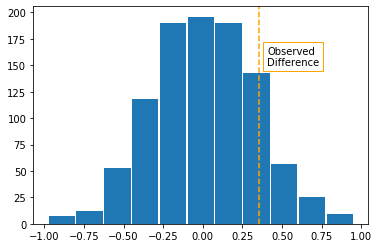

In [13]:
plt.hist(perm_diff, bins=11, rwidth=0.95)
plt.axvline(x=obs_diff, color='orange', ls='--')
plt.text(x=obs_diff+0.05, y=150, s='Observed\nDifference', 
         bbox={'facecolor':'white', 'edgecolor': 'orange'})
plt.show()

In [14]:
np.mean(perm_diff > obs_diff)  #p-value

0.133

11.5% chance that the mean difference of random permutations exceeds the observed difference in session time. This suggests that the observed difference between page A and B is within the range of chance variation and is not statistically significant.

---
## Statistical significance
Whether an experiment produces an outcome that is more extreme than random chance might do : the result is statistically significant if it is beyond the range of chance variation.

...and then p-value, alpha comes out! (with caution of Type 1 and 2 error)

In [15]:
ecommerce_experiment = pd.DataFrame({'Converted':[200, 182], 
                                     'Not Converted':[23539, 22406]}, 
                                    index=['Price A', 'Price B'])

In [16]:
ecommerce_experiment = ecommerce_experiment.T
ecommerce_experiment

,Price A,Price B
Converted,200,182
Not Converted,23539,22406


In [17]:
conv_rate = ecommerce_experiment.loc['Converted'] / ecommerce_experiment.sum(axis=0)
conv_rate

Price A    0.008425
Price B    0.008057
dtype: float64

In [18]:
obs_diff_conv = conv_rate[0] - conv_rate[1]
obs_diff_conv

0.0003675791182059275

Difference in conversion rate is by 0.03678, which may be big in a high-volumn buiness, but how significant is this result?

It looks that sample size is enough but it actually is not, as the actual meaningful values (converted) are not big enough : test the difference by using resampling method.

Previously defined permutation test is useful for this case.

In [19]:
def full_perm_test(X, nA, nB, num_iter, obs_val) :
    perm_diff = [perm_test_two(X, nA, nB) for _ in range(num_iter)]
    print(f'Observed Difference : {obs_val:.4f}%')
    print('P-value: ', np.mean(perm_diff > obs_val))

    plt.hist(perm_diff, bins=11, rwidth=0.95)
    plt.axvline(x=obs_val, color='orange', ls='--')
    plt.show()

In [20]:
# re-create samples that replicates the dataset
conversion = [0] * ecommerce_experiment.iloc[1].sum()
conversion.extend([1] * ecommerce_experiment.iloc[0].sum())

In [21]:
conversion = pd.Series(conversion)

Observed Difference : 0.0004%
P-value:  0.318


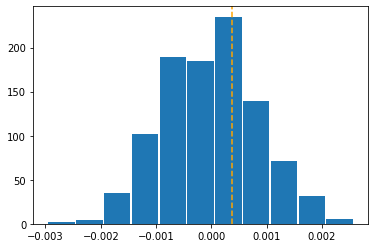

In [22]:
count_priceA = ecommerce_experiment['Price A'].sum()
count_priceB = ecommerce_experiment['Price B'].sum()

full_perm_test(conversion, count_priceA, count_priceB, 1000, obs_diff_conv)

P-value is 0.324, which means that we would expect to achieve a result as extreme as this, or a more extreme result, by random chance over 32% of the time. Conventionally alpha threshold is set at 1% or 5% level, and p-value above which indicates the outcome is not statistically significant. 

However, many argue (especially from academic side) p-value does not concretely prove as it seems to promise, and it is stressed that scientific conclusions or business/policy decisions should not be based only on a result drawn from p-value.

Also, practical significance must be considered. A small diference that has no practical meaning can be statistifcally significant for example.

---
## Significance tests

### t-tests

Before the computing power grew, it was not feasible to do resampling (shuffling thousand+ times), so t-test provided a good approximation to the permutation distribution.

Unlike resampling where the scale of the data does not really matter, t-test requires a standardized form of the test statistics. **`scipy.stats.ttest_ind`** can be used : two-sided test for the null hypothesis that 2 independent samples have identical average values.

**Web Stickiness** example continues where the null hypothesis is the session time for Page A > Page B (one-sided test)

In [35]:
# assuming the population of the two samples have different variances
results = stats.ttest_ind(sessions_pages.query('Page == "Page A"').Time,
                          sessions_pages.query('Page == "Page B"').Time,
                          equal_var=False, nan_policy='raise')

In [37]:
results.pvalue / 2  # p-value for one-sided test

0.140762186228503

The earlier permutation test returned the p-value of 0.133, which is fairly close to the p-value from the t-test.

<a id=bottom></a>
[Go to top](#top)